# **Brewing a PLS regressor**

# Introduction

Welcome to the world of spectroscopic data analysis, where we provide you with a unique insight into lignocellulosic ethanol fermentation in real-time. Our dataset comprises spectra obtained through attenuated total reflectance, mid-infrared (ATR-MIR) spectroscopy, combined with high-performance liquid chromatography (HPLC) reference data to ensure precision and accuracy.

Within this project, you’ll find two vital datasets:

- **Training Dataset**: This extensive resource includes both spectral data and corresponding HPLC measurements, serving as the foundation of our analysis.

- **Testing Dataset**: Immerse yourself in the fermentation process through a time series of real-time spectra. For a comprehensive view, we’ve also included off-line HPLC measurements.

For a deeper understanding of these datasets and their transformation of raw data into actionable insights, please refer to our comprehensive article: **“Transforming Data to Information: A Parallel Hybrid Model for Real-Time State Estimation in Lignocellulosic Ethanol Fermentation.”** It’s a journey into the world of data analysis, offering real-world applications. (Note that the data in the article and the one provided here do not correspond to the same fermentation.)

<div style="background: #e3f2fd; padding: 10px; border-left: 5px solid #2196F3; border-radius: 5px;">
    <strong>NOTE:</strong> <br>This is a step-by-step guide, that you should be able to run on your own computer. Just remember to install the <code>chemotools</code> package first using:<code>pip install chemotools<code>.
</div>

# Loading the training dataset
The Fermentation dataset is a valuable resource for investigating lignocellulosic ethanol fermentation. You can access it through the <code>chemotools.datasets</code> module using the <code>load_fermentation_train()</code> function:

In [44]:
from chemotools.datasets import load_fermentation_train

spectra, hplc = load_fermentation_train()


The <code>load_fermentation_train()</code> function returns two <code>pandas.DataFrame</code>:

- <code>spectra</code>: This dataset contains spectral data, with columns representing wavenumbers and rows representing samples.

- <code>hplc</code>: AHere, you’ll find HPLC measurements, specifically glucose concentrations (in g/L), stored in a single column labeled <code>glucose</code>.



<div style="background: #fff3e0; padding: 10px; border-left: 5px solid #FFC107; border-radius: 5px;">
    <strong>HIGHLIGHT:</strong> <br>
    If you are interested in working with <code>polars.DataFrame</code> you can simply use <code>load_fermentation_train(set_output="polars")</code> (/chemotools>=0.1.5). Note that if you choose to work with <code>polars.DataFrame</code> the wavenumbers are given in the column names as <code>str</code> and not as <code>float</code>. This is because <code>polars</code> does not support column names with types other than <code>str</code>. To extract the wavenumbers as <code>float</code> from the <code>polars.DataFrame</code> you can use the <code>df.columns.to_numpy(dtype=np.float64)</code> method.

</div>

# Exploring the training dataset
Before diving into data modeling, it’s essential to get familiar with your data. Start by answering basic questions: *How many samples are there?, and how many wavenumbers are available?*

In [45]:
print(f"Number of samples: {spectra.shape[0]}")
print(f"Number of wavenumbers: {spectra.shape[1]}")

Number of samples: 21
Number of wavenumbers: 1047


This should return the following output:<br>
    Number of samples: 21<br>
    Number of wavenumbers: 1047


Now that you have the basics down, let’s take a closer look at the data.

For the spectral data, you can use the <code>pandas.DataFrame.head()</code> method to examine the first 5 rows:

In [46]:
spectra.head()

,428.0,429.0,431.0,432.0,434.0,436.0,437.0,439.0,440.0,442.0,...,1821.0,1823.0,1824.0,1825.0,1826.0,1828.0,1829.0,1830.0,1831.0,1833.0
0,0.493506,-0.383721,0.356846,0.205714,0.217082,0.740331,0.581749,0.106719,0.507973,0.298643,...,0,0,0,0,0,0,0,0,0,0
1,0.108225,0.488372,-0.037344,0.448571,0.338078,0.632597,0.368821,0.462451,0.530752,0.221719,...,0,0,0,0,0,0,0,0,0,0
2,0.095238,0.790698,0.174274,0.314286,0.106762,0.560773,0.182510,0.482213,0.482916,0.341629,...,0,0,0,0,0,0,0,0,0,0
3,0.666667,0.197674,0.352697,0.385714,0.405694,0.508287,0.463878,0.430830,0.455581,0.527149,...,0,0,0,0,0,0,0,0,0,0
4,0.532468,-0.255814,0.078838,0.057143,0.238434,0.997238,0.399240,0.201581,0.533030,0.246606,...,0,0,0,0,0,0,0,0,0,0


For brevity, we won’t display the entire table here, but you’ll notice that each column corresponds to a wavenumber, and each row represents a sample.

Turning to the HPLC data, the <code>pandas.DataFrame.describe()</code> method provides a summary of the glucose column:

In [47]:
hplc.describe()

,glucose
count,21.000000
mean,19.063895
std,12.431570
min,0.000000
25%,9.057189
50%,18.395220
75%,29.135105
max,38.053004


This summary offers insights into the distribution of glucose concentrations. With this practical knowledge, you’re ready to embark on your data exploration journey.

| Statistic |    Glucose |
|----------:|-----------:|
| Count     | 21.000000  |
| Mean      | 19.063895  |
| Std       | 12.431570  |
| Min       |  0.000000  |
| 25%       |  9.057189  |
| 50%       | 18.395220  |
| 75%       | 29.135105  |
| Max       | 38.053004  |

# Visualizing the training dataset
To better understand our dataset, we employ visualization. We will plot the train dataset, with each spectrum color-coded to reflect its associated glucose concentration. This visual approach provides a didactic means to grasp the dataset’s characteristics, offering insights into chemical variations among the samples. To do so, we’ll use the <code>matplotlib.pyplot</code> module. Remember to install it first using:

```bash
pip install matplotlib

Up until now, we have used <code>pandas.DataFrame</code> to represent the dataset. <code>pandas.DataFrame</code> are great for storing and manipulating many large datasets. However, I often find more convenient to use <code>numpy.ndarray</code> to work with spectral data. Therefore, we will convert the <code>pandas.DataFrame</code> to <code>numpy.ndarra</code> using the <code>pandas.DataFrame.to_numpy()</code> method.

<div style="background: #e3f2fd; padding: 10px; border-left: 5px solid #2196F3; border-radius: 5px;">
    <p><strong>NOTE:</strong></p>
    <p>Pandas 🐼 or polars 🐻‍❄️ lover ❤️? No problem! <code>chemotools</code> also supports working with <code>pandas.DataFrame</code> or <code>polars.DataFrame</code> by implementing the latest <code>set_output()</code> API from <code>scikit-learn</code>. If you are more interested in working with <code>pandas</code> or <code>polars</code>, take a look at the documentation <a href="https://paucablop.github.io/chemotools/get-started/scikit_learn_integration.html#working-with-dataframes">here</a>.</p>
</div>

So our first step will be to transform our `pandas.DataFrame` to `numpy.ndarray`:

In [48]:
import numpy as np

# Convert the spectra pandas.DataFrame to numpy.ndarray
spectra_np = spectra.to_numpy()

# Convert the wavenumbers pandas.columns to numpy.ndarray
wavenumbers = spectra.columns.to_numpy(dtype=np.float64)

# Convert the hplc pandas.DataFrame to numpy.ndarray
hplc_np = hplc.to_numpy()

Now that we have our data in the right format, we can start plotting. We will define a function to plot the spectra, where each spectrum will be color-coded according to its glucose concentration. We will use the `matplotlib.colors.Normalize` class to normalize the glucose concentrations between 0 and 1. Then, we will use the `matplotlib.cm.ScalarMappable` class to create a colorbar.

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_spectra(spectra: np.ndarray, wavenumbers: np.ndarray, hplc: np.ndarray, zoom_in=False):
    # Define a colormap
    cmap = plt.get_cmap("cool")

    # Define a normalization function to scale glucose concentrations between 0 and 1
    normalize = Normalize(vmin=hplc.min(), vmax=hplc.max())
    colors = [cmap(normalize(value)) for value in hplc]

    # Plot the spectra
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, row in enumerate(spectra):
        ax.plot(wavenumbers, row, color=colors[i])

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Glucose (g/L)')

    # Add labels
    ax.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax.set_ylabel('Absorbance (a.u.)')
    ax.set_title('Fermentation training set')
    if zoom_in:
        ax.set_xlim(950, 1550)
        ax.set_ylim(0.45, 0.65)

    plt.show()

Then, we can use this function to plot the training dataset:

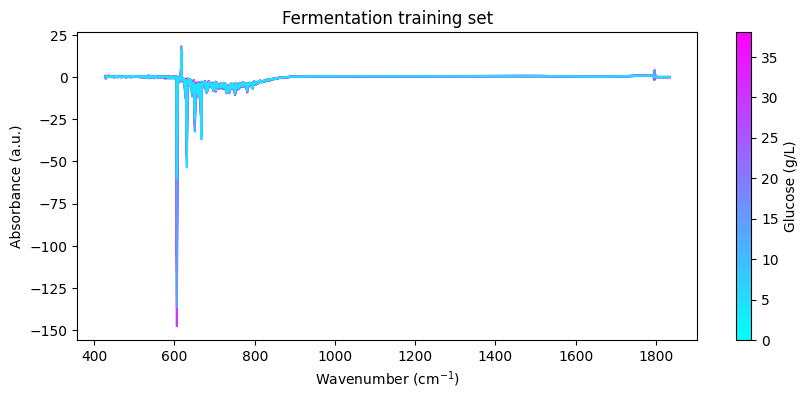

In [50]:
plot_spectra(spectra_np, wavenumbers, hplc_np)

Ok, these are not very beautiful spectra. This is because they are recorded over a long wavenumber range, where there is a large section without chemical information. Let's zoom in on the region between **950 and 1550 cm<sup>-1</sup>**, where we can see some interesting features:

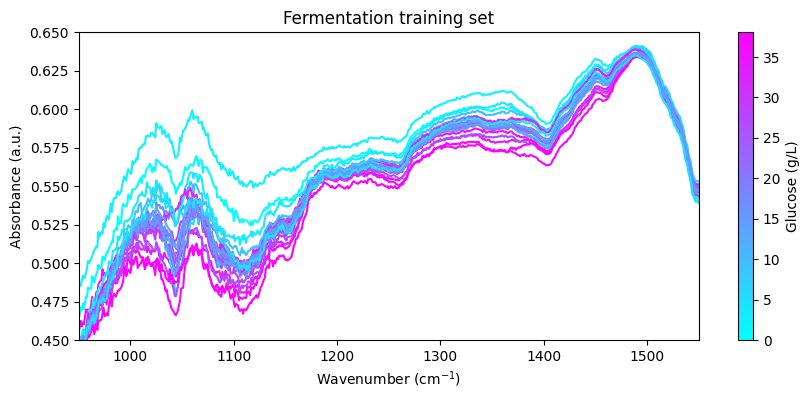

In [51]:
plot_spectra(spectra_np, wavenumbers, hplc_np, zoom_in=True)


# Preprocessing the training spectra

Now that you've explored the dataset, it's time to preprocess the spectral data. This step is essential for removing unwanted variations, such as baseline shifts and noise, which can negatively impact model performance. We'll use the `chemotools` and the `scikit-learn` modules to preprocess the spectral data. 

We will preprocess the spectra using the following steps:
- **[Range Cut](https://paucablop.github.io/chemotools/docs/feature_selection.html#range-cut)**: to remove the wavenumbers outside the range between 950 and 1550 cm<sup>-1</sup>.

- **[Linear Correction](https://paucablop.github.io/chemotools/docs/baseline.html#linear-baseline-correction)**: to remove the linear baseline shift.

- **[Savitzky-Golay](https://paucablop.github.io/chemotools/docs/derivative.html#savitzky-golay-derivative)**: calculates the n<sup>th</sup> order derivative of the spectra using the Savitzky-Golay method. This is useful to remove additive and multiplicative scatter effects.

- **[Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**: to scale the spectra to zero mean.


We will chain the preprocessing steps using the [```make_pipeline()```](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function from ```scikit-learn```. _What is a pipeline?_ A pipeline is a sequence of steps that are executed in a specific order. In our case, we will create a pipeline that will execute the preprocessing steps in the order described above. You can find more information on working with pipelines at our [documentation page](https://paucablop.github.io/chemotools/get-started/scikit_learn_integration.html#working-with-pipelines).




In [52]:
from chemotools.feature_selection import RangeCut
from chemotools.baseline import LinearCorrection
from chemotools.derivative import SavitzkyGolay

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# create a pipeline that scales the data
preprocessing = make_pipeline(
    RangeCut(start=950, end=1500, wavenumbers=wavenumbers),
    LinearCorrection(),
    SavitzkyGolay(window_size=15, polynomial_order=2, derivate_order=1),
    StandardScaler(with_std=False)
)


Now we can use the preprocessing pipeline to preprocess the spectra:

In [53]:
spectra_preprocessed = preprocessing.fit_transform(spectra_np)

Now we can use the preprocessing pipeline to preprocess the spectra:

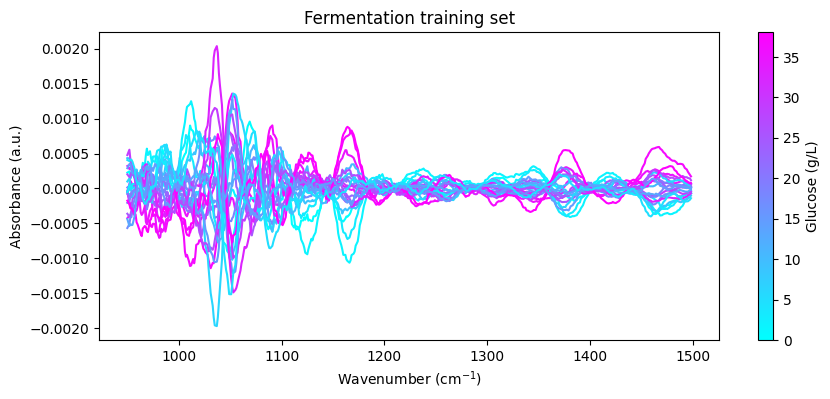

In [54]:
# get the wavenumbers after the range cut
wavenumbers_cut = preprocessing.named_steps['rangecut'].wavenumbers_


# plot the preprocessed spectra
plot_spectra(spectra_preprocessed, wavenumbers_cut, hplc_np)



<div style="background-color: #e6f3ff; padding: 10px; border-left: 5px solid #007bff; margin: 10px 0;">
    <p><strong>Note:</strong> <br>
    This is cool! See how we are integrating chemometrics with scikit-learn? <code>RangeCut</code>, <code>LinearCorrection</code>, and <code>SavitizkyGolay</code> are all preprocessing techniques implemented in <code>chemotools</code>, while <code>StandardScaler</code> and pipelines are functionalities provided by <code>scikit-learn</code>. This is the power of <code>chemotools</code>—it is designed to work seamlessly with <code>scikit-learn</code>.</p>
</div>

# Training a PLS model

A Partial Least Squares (PLS) model is a bilinear regression model that is widely used in chemometrics. It is a regression algorithm that will learn a latent space representation of the data that has a maximum covariance with the target variable. A crucial parameter of the PLS model is the dimension of the latent space (often referred to as number of components). Selecting a number of components that is too large, will result in overfitting, as the latent space will start describing the noise in the data. On the other hand, selecting a number of components that is too small, will result in underfitting, as the latent space will not be able to capture the relevant information in the data. Therefore, it is important to select the right number of components.

Finding the right number of components can be challenging, specially when the number of samples is not so large. For this reason, a powerfull tool to select the number of components is cross-validation. Cross-validation is a technique that allows us to estimate the generalization error of a model. The idea is to split the data into a training and a validation set. Then, we train the model on the training set and evaluate its performance on the validation set. We repeat this process several times, each time using a different split of the data. Finally, we average the performance of the model over all the splits. This will give us an estimate of the generalization error of the model.

We will use the cross-validation functionalities provided by scikit-learn to find the optimal numbers of components for our PLS model. We will use the GridSearchCV class to perform a grid search over the number of components. The GridSearchCV class will perform a cross-validation for each number of components in the grid and return the optimal number of components.

In [55]:
# import the PLSRegression and GridSearchCV classes
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV

# instanciate a PLSRegression object
pls = PLSRegression(scale=False)

# define the parameter grid (number of components to evaluate)
param_grid = {'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# create a grid search object
grid_search = GridSearchCV(pls, param_grid, cv=10, scoring='neg_mean_absolute_error')

# fit the grid search object to the data
grid_search.fit(spectra_preprocessed, hplc_np)

# print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", np.abs(grid_search.best_score_))

Best parameters:  {'n_components': 6}
Best score:  0.9229440262463037


This returns the following output:<br>
Fitting 10 folds for each of 10 candidates, totalling 100 fits<br>
Best parameters:  {'n_components': 6}<br>
Best score:  0.9229440262462993

Suggesting that the optimal number of components is 6, with a mean absolute error of 0.92 g/L. We can verify this by plotting the mean absolute error as a function of the number of components:

Text(0.5, 1.0, 'Cross validation results')

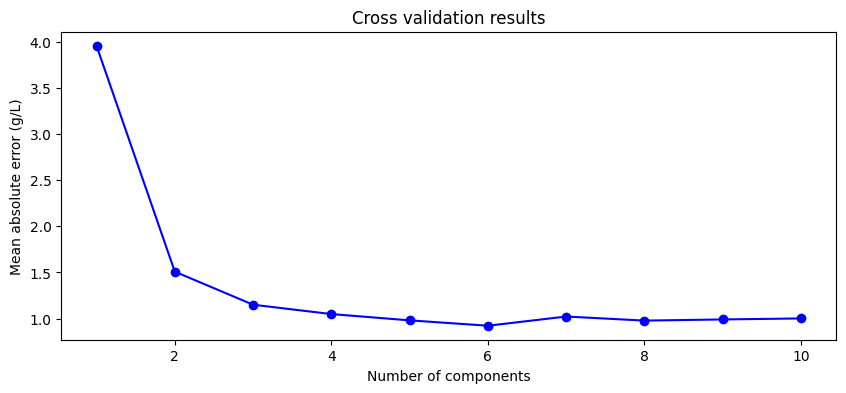

In [57]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(param_grid['n_components'], np.abs(grid_search.cv_results_['mean_test_score']), marker='o', color='b')
ax.set_xlabel('Number of components')
ax.set_ylabel('Mean absolute error (g/L)')
ax.set_title('Cross validation results')

<div style="background: #e3f2fd; padding: 10px; border-left: 5px solid #2196F3; border-radius: 5px;">
    <p><strong>NOTE:</strong></p>
    <p>Even though using the number of components that minimize the mean absolute error is a good starting point, it is not always the best. The model with 6 components does not increase the mean absolute error much compared to the model with 3 or even two components. However, the model with 6 components includes components associated with small eigenvalues, which are more uncertain. This means that models with 3 or 2 components might be more robust. Therefore, it is always a good idea to try different numbers of components and select the one that gives the best performance.</p>
</div>

For now, we will train the model with 6 components:

In [58]:
# instanciate a PLSRegression object with 6 components
pls = PLSRegression(n_components=6, scale=False)

# fit the model to the data
pls.fit(spectra_preprocessed, hplc_np)

PLSRegression(n_components=6, scale=False)

Finally we can evaluate the performance of the model on the training set:

Text(0.5, 1.0, 'PLS regression')

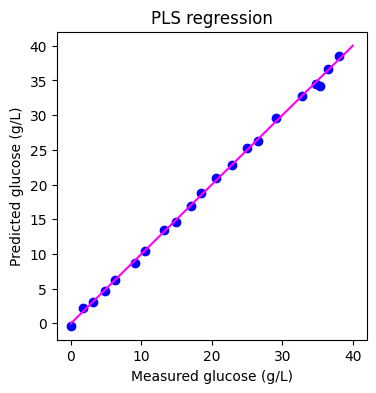

In [59]:
# predict the glucose concentrations
hplc_pred = pls.predict(spectra_preprocessed)

# plot the predictions
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(hplc_np, hplc_pred, color='blue')
ax.plot([0, 40], [0, 40], color='magenta')
ax.set_xlabel('Measured glucose (g/L)')
ax.set_ylabel('Predicted glucose (g/L)')
ax.set_title('PLS regression')

# Applying the model to the testing dataset

Now that we have trained our model, we can apply it to the testing dataset. The testing dataset contains spectra recorded in real-time during the fermentation process. The test dataset contains two `pandas.DataFrame`:

- `spectra`: This dataset contains spectral data, with columns representing wavenumbers and rows representing samples. These spectra were recorded in real-time during the fermentation process approximately every 1.5 minutes.

- `hplc`: This dataset contains HPLC measurements, specifically glucose concentrations (in g/L), stored in a single column labeled `glucose`. These measurements were recorded off-line approximately every 60 minutes.

We will use the `load_fermentation_test()` function from the `chemotools.datasets` module to load the testing dataset:

In [60]:
from chemotools.datasets import load_fermentation_test

spectra_test, hplc_test = load_fermentation_test()

Then, we will preprocess the spectra using the same preprocessing pipeline that we used for the training dataset:

In [61]:
# convert the spectra pandas.DataFrame to numpy.ndarray
spectra_test_np = spectra_test.to_numpy()

# preprocess the spectra
spectra_test_preprocessed = preprocessing.transform(spectra_test_np)

Finally, we can use the PLS model to predict the glucose concentrations:

In [62]:
# predict the glucose concentrations
glucose_test_pred = pls.predict(spectra_test_preprocessed)

We can use the predicted values to plot the spectra color-coded according to the predicted glucose concentrations:

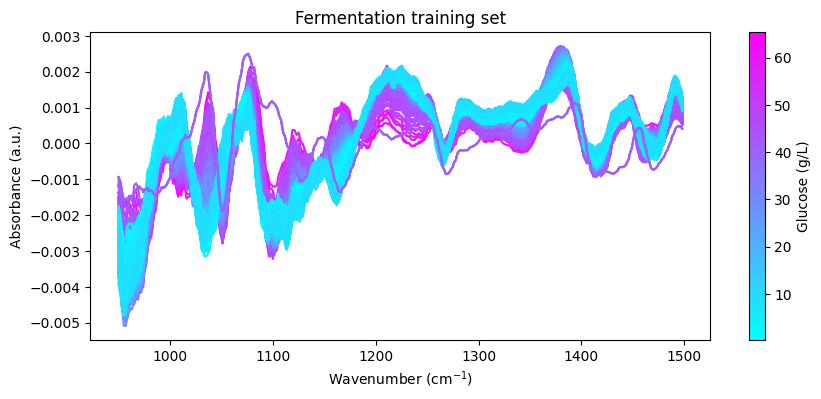

In [63]:
plot_spectra(spectra_test_preprocessed, wavenumbers_cut, glucose_test_pred)

Now we can compare the predicted glucose concentrations with the off-line HPLC measurements. We will plot the predictions and the off-line measurements over time. Each spectrum was taken every 1.25 minutes, while the off-line measurements were taken every 60 minutes.

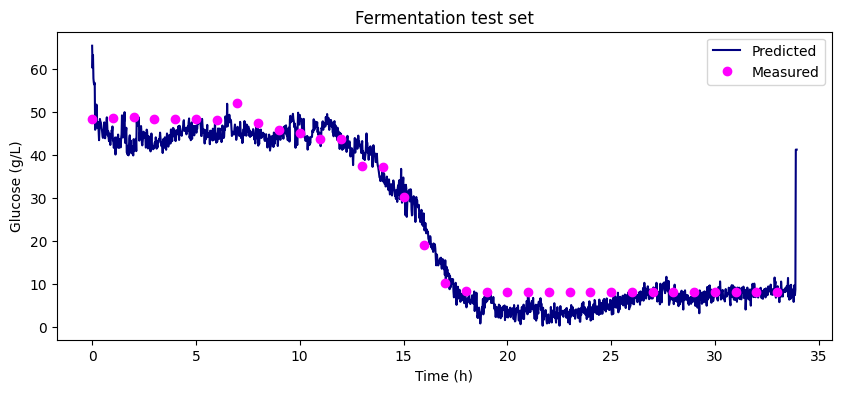

In [67]:
# make linspace of length of predictoins
time = np.linspace(0, len(glucose_test_pred), len(glucose_test_pred),) * 1.25 / 60

# plot the predictions
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time, glucose_test_pred,  color='navy', label='Predicted')
ax.plot(hplc_test.index, hplc_test['glucose']+4, 'o', color='fuchsia', label='Measured')
ax.set_xlabel('Time (h)')
ax.set_ylabel('Glucose (g/L)')
ax.set_title('Fermentation test set')
ax.legend()

# Recap

In this tutorial, we embarked on a journey into the realm of machine learning for spectroscopic data analysis, focusing on the Fermentation dataset. We covered essential steps in building a regression model to predict glucose concentrations during lignocellulosic ethanol fermentation. Here’s a brief recap of what we accomplished:

- Introduction: We introduced the Fermentation dataset, which consists of spectral data obtained through attenuated total reflectance, mid-infrared spectroscopy (ATR-MIR), and HPLC reference data. We highlighted the importance of this dataset in understanding real-time fermentation processes.

- Loading and Exploring Data: We loaded the training dataset, explored its dimensions, and gained insights into both spectral and HPLC data. Understanding your data is a crucial first step in any data analysis project.

- Visualizing Data: We used data visualization to gain a deeper understanding of the dataset. By plotting the spectra color-coded by glucose concentration, we visually examined the chemical variations among samples.

- Preprocessing Data: We applied preprocessing techniques, such as range cutting, linear correction, Savitzky-Golay derivative, and standard scaling, to prepare the spectral data for modeling. This step removed unwanted variations and enhanced the data’s quality.

- Model Training: We trained a Partial Least Squares (PLS) regression model to predict glucose concentrations. We used cross-validation to find the optimal number of components and assessed model performance.

- Application to Testing Data: We extended our model to predict glucose concentrations in real-time by applying it to the testing dataset. This allowed us to monitor glucose levels during fermentation.

This tutorial provides a solid foundation for anyone interested in using machine learning techniques for spectroscopic data analysis. By following these steps, you can gain valuable insights from complex spectral data and make predictions that can be applied in real-world applications. Happy analyzing!